In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from glob import glob
import matplotlib.pyplot as plt
import mne
import numpy as np
import os
import pandas as pd
import re
import sys
from tqdm.auto import tqdm

sys.path.append('..')
from dynamical_models import compute_VAR

# Load Data

In [3]:
EEG_dir = '/om/user/eisenaj/datasets/Get_Sleep_data/EEG'
annotation_dir = '/om/user/eisenaj/datasets/Get_Sleep_data/annotations'

In [33]:
sub = 17
day = 2

In [34]:
# load the data
raw = mne.io.read_raw_brainvision(
        glob(os.path.join(EEG_dir,f'suj{sub}_' + 'l*' + f'nap_day{day}.vhdr'))[0],
        preload = True)
# set the EOG channels
channel_types = {'LOc':'eog','ROc':'eog','Aux1':'misc'}
raw.set_channel_types(channel_types)
raw.filter(0.5, 100)
dt = 1/raw.info['sfreq']
eeg_df = raw.to_data_frame()

Extracting parameters from /om/user/eisenaj/datasets/Get_Sleep_data/EEG/suj17_l2nap_day2.vhdr...
Setting channel info structure...
Reading 0 ... 1811799  =      0.000 ...  1811.799 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6601 samples (6.601 sec)



In [35]:
all_electrodes = [c for c in eeg_df.columns if c not in ['time', 'LOc', 'ROc', 'Aux1']]
all_eeg = eeg_df[all_electrodes].to_numpy()

In [36]:
'Fp1' in all_electrodes, 'Fp2' in all_electrodes

(True, True)

In [37]:
# read annotations
events = pd.read_csv(os.path.join(annotation_dir,
                                    f'suj{sub}_day{day}_annotations.txt'))

In [38]:
sleep_stages = []
ontime = None
for i, row in tqdm(events.iterrows(), total=len(events)):
    if row.Annotation != 'spindle' and row.Annotation != 'k-complex' and row.Annotation != 'spindle ':
        if row.Annotation.split(':')[1] == 'Markon' or row.Annotation.split(':')[1] == ' Markon':
            ontime = row.Onset
        elif row.Annotation.split(':')[1] == 'Markoff' or row.Annotation.split(':')[1] == ' Markoff':
            stage = row.Annotation.split(':')[-1]
            if stage == ' w':
                stage = 'w'
            elif stage == ' 1':
                stage = '1'
            elif stage == ' 2':
                stage = '2'
            sleep_stages.append(dict(
                start_time=ontime,
                end_time=row.Onset,
                duration=row.Onset - ontime,
                sleep_stage=stage
            ))
hypnogram_df = pd.DataFrame(sleep_stages)

  0%|          | 0/261 [00:00<?, ?it/s]

# Compute VAR

In [ ]:
VAR_results = {}
windows = [0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
# windows = [10]

# for area in ['frontal', 'posterior', 'very-frontal', 'all']:
# for area in ['frontal', 'posterior', 'very-frontal', 'pre-frontal', 'all']:
for area in ['frontal', 'very-frontal', 'all']:
# for area in ['test']:
    
    VAR_results[area] = {}
    
    if area == 'frontal':
        unit_indices = [i for i, c in enumerate(all_electrodes) if c.startswith('F') or c.startswith("AF")]
    elif area == 'posterior':
        unit_indices = [i for i, c in enumerate(all_electrodes) if not c.startswith('F') and not c.startswith("AF")]
    elif area == 'very-frontal':
        unit_indices = [i for i, c in enumerate(all_electrodes) if c.startswith('Fp') or c.startswith("AF")]
    elif area == 'pre-frontal':
        unit_indices = [i for i, c in enumerate(all_electrodes) if c.startswith('Fp')]
#     elif area == 'test':
#         unit_indices = [i for i, c in enumerate(all_electrodes) if c == 'Fp1' or c == 'Pz']
    else: # area == 'all'
        unit_indices = np.arange(len(all_electrodes))

    
    for window in windows:
# for area in ['pre-frontal']:
        print(f"now computing area = {area}, window = {window}")
        stride = window

        num_windows = int(np.floor((all_eeg.shape[0]-int(window/dt))/int(stride/dt))+1)

        all_results = []
        for i in tqdm(range(num_windows)):
            start_ind = i*int(stride/dt)
            end_ind = i*int(stride/dt) + int(window/dt)
            window_data = all_eeg[start_ind:end_ind]

            try:
                results = compute_VAR(window_data, unit_indices=unit_indices)
                results['start_time'] = i*stride
                results['start_time_ms'] = i*stride*1000
                results['start_ind'] = start_ind
                results['end_time'] = i*stride + window
                results['end_time_ms'] = (i*stride + window)*1000
                results['end_ind'] = end_ind
                all_results.append(results)
            except:
                pass
                # sometimes this doesn't work because the EEG isn't aligned at the beginning/end
        VAR_results[area][window] = pd.DataFrame(all_results)

now computing area = frontal, window = 0.2


  0%|          | 0/9059 [00:00<?, ?it/s]

now computing area = frontal, window = 0.3


  0%|          | 0/6039 [00:00<?, ?it/s]

now computing area = frontal, window = 0.4


  0%|          | 0/4529 [00:00<?, ?it/s]

now computing area = frontal, window = 0.5


  0%|          | 0/3623 [00:00<?, ?it/s]

now computing area = frontal, window = 1


  0%|          | 0/1811 [00:00<?, ?it/s]

now computing area = frontal, window = 1.5


  0%|          | 0/1207 [00:00<?, ?it/s]

now computing area = frontal, window = 2


  0%|          | 0/905 [00:00<?, ?it/s]

now computing area = frontal, window = 2.5


  0%|          | 0/724 [00:00<?, ?it/s]

now computing area = frontal, window = 3


  0%|          | 0/603 [00:00<?, ?it/s]

now computing area = frontal, window = 3.5


  0%|          | 0/517 [00:00<?, ?it/s]

now computing area = frontal, window = 4


  0%|          | 0/452 [00:00<?, ?it/s]

now computing area = frontal, window = 4.5


  0%|          | 0/402 [00:00<?, ?it/s]

now computing area = frontal, window = 5


  0%|          | 0/362 [00:00<?, ?it/s]

now computing area = frontal, window = 6


  0%|          | 0/301 [00:00<?, ?it/s]

now computing area = frontal, window = 6.5


  0%|          | 0/278 [00:00<?, ?it/s]

now computing area = frontal, window = 7


  0%|          | 0/258 [00:00<?, ?it/s]

now computing area = frontal, window = 7.5


  0%|          | 0/241 [00:00<?, ?it/s]

now computing area = frontal, window = 8


  0%|          | 0/226 [00:00<?, ?it/s]

now computing area = frontal, window = 8.5


  0%|          | 0/213 [00:00<?, ?it/s]

now computing area = frontal, window = 9


  0%|          | 0/201 [00:00<?, ?it/s]

now computing area = frontal, window = 9.5


  0%|          | 0/190 [00:00<?, ?it/s]

now computing area = frontal, window = 10


  0%|          | 0/181 [00:00<?, ?it/s]

now computing area = very-frontal, window = 0.2


  0%|          | 0/9059 [00:00<?, ?it/s]

now computing area = very-frontal, window = 0.3


  0%|          | 0/6039 [00:00<?, ?it/s]

now computing area = very-frontal, window = 0.4


  0%|          | 0/4529 [00:00<?, ?it/s]

now computing area = very-frontal, window = 0.5


  0%|          | 0/3623 [00:00<?, ?it/s]

now computing area = very-frontal, window = 1


  0%|          | 0/1811 [00:00<?, ?it/s]

now computing area = very-frontal, window = 1.5


  0%|          | 0/1207 [00:00<?, ?it/s]

now computing area = very-frontal, window = 2


  0%|          | 0/905 [00:00<?, ?it/s]

now computing area = very-frontal, window = 2.5


  0%|          | 0/724 [00:00<?, ?it/s]

now computing area = very-frontal, window = 3


  0%|          | 0/603 [00:00<?, ?it/s]

now computing area = very-frontal, window = 3.5


  0%|          | 0/517 [00:00<?, ?it/s]

now computing area = very-frontal, window = 4


  0%|          | 0/452 [00:00<?, ?it/s]

now computing area = very-frontal, window = 4.5


  0%|          | 0/402 [00:00<?, ?it/s]

now computing area = very-frontal, window = 5


  0%|          | 0/362 [00:00<?, ?it/s]

now computing area = very-frontal, window = 6


  0%|          | 0/301 [00:00<?, ?it/s]

now computing area = very-frontal, window = 6.5


  0%|          | 0/278 [00:00<?, ?it/s]

now computing area = very-frontal, window = 7


  0%|          | 0/258 [00:00<?, ?it/s]

now computing area = very-frontal, window = 7.5


  0%|          | 0/241 [00:00<?, ?it/s]

now computing area = very-frontal, window = 8


  0%|          | 0/226 [00:00<?, ?it/s]

now computing area = very-frontal, window = 8.5


  0%|          | 0/213 [00:00<?, ?it/s]

# Window Selection

In [11]:
T_pred = 10

predictions = {}
true_vals = {}
step_mse = {}
for area in VAR_results.keys():
    predictions[area] = {}
    true_vals[area] = {}
    step_mse[area] = {}
    
for window in windows:
    stride = window
    print(f"Now computing window = {window}")

    for area in VAR_results.keys():
        if area == 'frontal':
            unit_indices = [i for i, c in enumerate(all_electrodes) if c.startswith('F') or c.startswith("AF")]
        elif area == 'posterior':
            unit_indices = [i for i, c in enumerate(all_electrodes) if not c.startswith('F') and not c.startswith("AF")]
        elif area == 'very-frontal':
            unit_indices = [i for i, c in enumerate(all_electrodes) if c.startswith('Fp') or c.startswith("AF")]
        elif area == 'pre-frontal':
            unit_indices = [i for i, c in enumerate(all_electrodes) if c.startswith('Fp')]
        else: # area == 'all'
            unit_indices = np.arange(len(all_electrodes))
            
        predictions[area][window] = np.zeros((len(VAR_results[area][window]) - 1, T_pred, len(unit_indices)))
        true_vals[area][window] = np.zeros(predictions[area][window].shape)

        for i in tqdm(range(predictions[area][window].shape[0])):
            row = VAR_results[area][window].iloc[i]
            start_step = int(stride*i/dt)
            x0 = all_eeg[start_step + int(window/dt) - 1, unit_indices]

            for t in range(T_pred):
                predictions[area][window][i, t] = np.hstack([[1], all_eeg[start_step + int(window/dt) - 1 + t, unit_indices]]) @ row.A_mat_with_bias
#                 if t == 0:
#                     predictions[area][window][i, t] = np.hstack([[1], x0]) @ row.A_mat_with_bias
#                 else:
#                     predictions[area][window][i, t] = np.hstack([[1], predictions[area][window][i, t - 1]]) @ row.A_mat_with_bias

            true_vals[area][window][i] = all_eeg[start_step + int(window/dt):start_step + int(window/dt) + T_pred, unit_indices]

        step_mse[area][window] = ((predictions[area][window] - true_vals[area][window])**2).mean(axis=2)

Now computing window = 0.2


  0%|          | 0/9018 [00:00<?, ?it/s]

  0%|          | 0/9018 [00:00<?, ?it/s]

  0%|          | 0/9018 [00:00<?, ?it/s]

Now computing window = 0.3


  0%|          | 0/6011 [00:00<?, ?it/s]

  0%|          | 0/6011 [00:00<?, ?it/s]

  0%|          | 0/6011 [00:00<?, ?it/s]

Now computing window = 0.4


  0%|          | 0/4508 [00:00<?, ?it/s]

  0%|          | 0/4508 [00:00<?, ?it/s]

  0%|          | 0/4508 [00:00<?, ?it/s]

Now computing window = 0.5


  0%|          | 0/3606 [00:00<?, ?it/s]

  0%|          | 0/3606 [00:00<?, ?it/s]

  0%|          | 0/3606 [00:00<?, ?it/s]

Now computing window = 1


  0%|          | 0/1802 [00:00<?, ?it/s]

  0%|          | 0/1802 [00:00<?, ?it/s]

  0%|          | 0/1802 [00:00<?, ?it/s]

Now computing window = 1.5


  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/1201 [00:00<?, ?it/s]

Now computing window = 2


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Now computing window = 2.5


  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

Now computing window = 3


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Now computing window = 3.5


  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

Now computing window = 4


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

Now computing window = 4.5


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

Now computing window = 5


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/359 [00:00<?, ?it/s]

Now computing window = 6


  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

Now computing window = 6.5


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

Now computing window = 7


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Now computing window = 7.5


  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

Now computing window = 8


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

Now computing window = 8.5


  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Now computing window = 9


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

Now computing window = 9.5


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Now computing window = 10


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

In [12]:
pct_of_value = 0.95

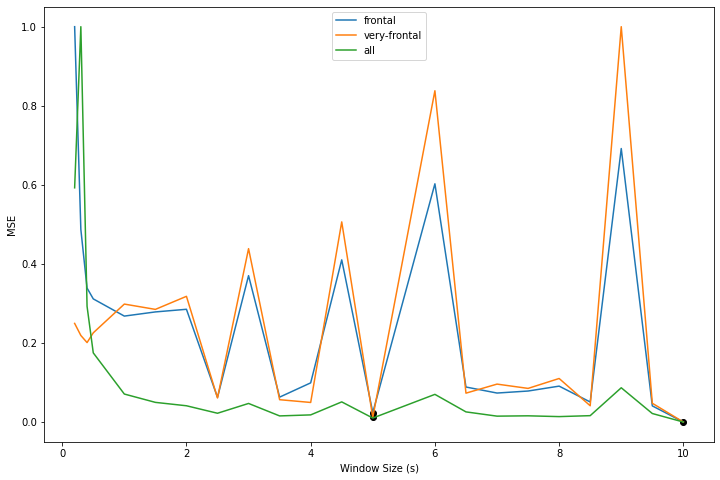

In [16]:
selected_windows = {}
plt.figure(figsize=(12, 8))
pred_steps = 10
for area in VAR_results.keys():
    window_mses = [step_mse[area][window][:].mean() for window in windows]
    
    asymptotic_value = np.array(window_mses).min()
    asymptotic_ind = np.argmin(window_mses)
    for i in range(len(window_mses)):
        if window_mses[i]*pct_of_value <= asymptotic_value or i == asymptotic_ind:
            selected_windows[area] = windows[i]
            break

#     plt.plot(windows, window_mses, label=area)
#     plt.plot(selected_windows)
    
for i, area in enumerate(step_mse.keys()):
#     ax = axs[int(i/2), i % 2]
    mse_per_window = np.array([step_mse[area][window][:].mean() for window in windows])
    min_val = mse_per_window.min()
    max_val = mse_per_window.max()
    mse_per_window -= min_val
    mse_per_window /= max_val - min_val
    plt.plot(windows, mse_per_window, label=area)
    pt = step_mse[area][selected_windows[area]][:].mean()
    pt -= min_val
    pt /= max_val - min_val
#         if num == 2 and area == '7b':
#             print(mse_per_window*0.95)
#             print(pt)
    plt.scatter(selected_windows[area], pt, color='k')
    
plt.xlabel("Window Size (s)")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [17]:
selected_windows

{'frontal': 5, 'very-frontal': 5, 'all': 10}

In [18]:
# area = 'frontal'
# window = 0.3

In [19]:
# time_in_session = 15*60 + 9.5 # s
# window_num = int(time_in_session/window)

In [20]:
# rows = 5
# cols = 5
# fig, axs = plt.subplots(rows, cols, figsize=(15, 8), sharex=True)
# unit_nums = np.arange(rows*cols)
# # unit_nums = np.random.choice(predictions[area][window].shape[2], size=(rows*cols,), replace=False)
# for i, unit_num in enumerate(unit_nums):
#     ax = axs[int(i/rows)][i%rows]
#     ax.plot(true_vals[area][window][window_num, :, unit_num], label='true_vals')
#     ax.plot(predictions[area][window][window_num, :, unit_num], label='predictions')
#     ax.set_title(f'Unit #{unit_num}')
# plt.suptitle(f"Predictions Across Randomly Choosen Units\narea = {area}, window = {window}, {int(time_in_session/window)*window}s into session\nMSE on this window at final step = {step_mse[area][window][window_num, -1]:.6f}, MSE on Whole Session at Final Step = {step_mse[area][window][:, -1].mean():.6f}\nMSE on this window at all steps = {step_mse[area][window][window_num, :].mean():.6f}, MSE on Whole Session at Final Step = {step_mse[area][window][:, :].mean():.6f}")
# plt.tight_layout()
# plt.show()

# Plot

In [21]:
colors = {'W': 'limegreen', 'w': 'limegreen', '1': 'gold', '2': 'darkorange', '3': 'coral', 'SWS': 'coral', '4': 'indianred', 'R': 'magenta', '?': 'gray', 'e': 'gray'}

In [22]:
window = 5

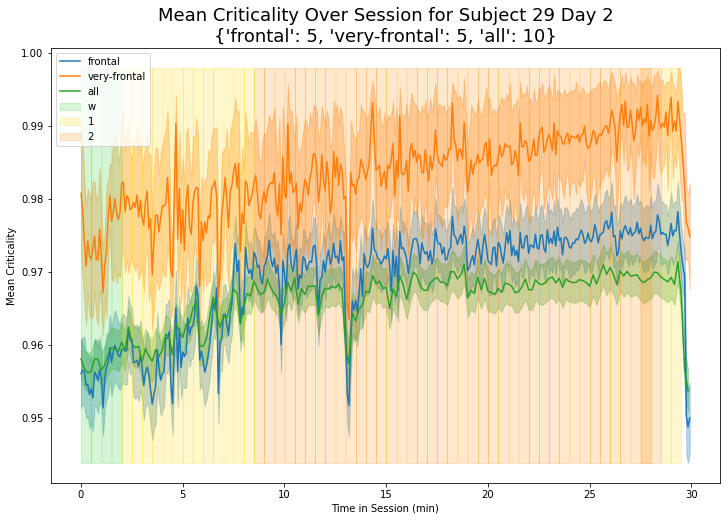

In [31]:
plt.figure(figsize=(12, 8))
min_val = np.Inf
max_val = -np.Inf
for i, area in enumerate(VAR_results.keys()):
# for area in ['frontal']:
    time_vals = VAR_results[area][selected_windows[area]].start_time
    mean_vals = VAR_results[area][selected_windows[area]].criticality_inds.apply(lambda x: x.mean())
    plt.plot(time_vals/60, mean_vals, label=area)
    std_error = VAR_results[area][selected_windows[area]].criticality_inds.apply(lambda x: x.std()/np.sqrt(len(x)))
    if (mean_vals - std_error).min() < min_val:
        min_val = (mean_vals - std_error).min()
    if (mean_vals + std_error).max() > max_val:
        max_val = (mean_vals + std_error).max()
    plt.fill_between(time_vals/60, mean_vals - std_error, mean_vals + std_error, color=f"C{i}", alpha=0.3)
plt.xlabel('Time in Session (min)')
plt.ylabel("Mean Criticality")


seen = {}
for stage in colors.keys():
    seen[stage] = False
for i, row in hypnogram_df.iterrows():
    plt.fill_between(np.arange(row.start_time, row.end_time)/60, min_val, max_val, color=colors[row.sleep_stage], label=row.sleep_stage if not seen[row.sleep_stage] else "", alpha=0.2)
    seen[row.sleep_stage] = True
plt.legend()
plt.title(f"Mean Criticality Over Session for Subject {sub} Day {day}\n{selected_windows}", fontsize=18)
plt.show()

# Binning

In [25]:
for area in VAR_results.keys():
    VAR_results[area][window]['sleep_stage'] = [None]*len(VAR_results[area][window])
    for i, row in tqdm(VAR_results[area][window].iterrows(), total=len(VAR_results[area][window])):
        sleep_stage_counts = {'w': 0, '1': 0, '2': 0, 'SWS': 0}

        start_time_bool = hypnogram_df.start_time <= row.start_time
        start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(hypnogram_df) else len(hypnogram_df) - 1
        end_time_bool = hypnogram_df.end_time > row.end_time
        end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(hypnogram_df) - 1

        for row_ind in range(start_row, end_row + 1):
            row2 = hypnogram_df.iloc[row_ind]

            if row2.start_time <= row.start_time:
                start_in_chunk = row.start_time - row2.start_time
            else:
                start_in_chunk = 0

            if row2.end_time <= row.end_time:
                end_in_chunk = row2.duration
            else:
                end_in_chunk = row.end_time - row2.start_time

            sleep_stage_counts[row2.sleep_stage] += end_in_chunk - start_in_chunk

        VAR_results[area][window].loc[i, 'sleep_stage'] = max(sleep_stage_counts, key=sleep_stage_counts.get)

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

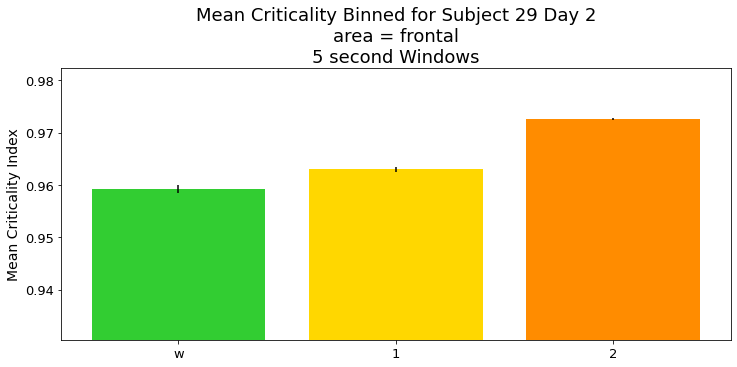

In [32]:
area = 'frontal'
plt.figure(figsize=(12, 5))
mean_criticality_sleep_stage = []
std_error_sleep_stage = []
sleep_stage = []
sleep_stage_colors = []
for s in colors.keys():
    if s != '?' and s != 'e':
        if np.sum(VAR_results[area][window].sleep_stage == s) > 0:
            sleep_stage.append(s)
            all_inds = np.vstack(VAR_results[area][window][VAR_results[area][window].sleep_stage == s].criticality_inds.to_numpy()).flatten()
            mean_criticality_sleep_stage.append(all_inds.mean())
            std_error_sleep_stage.append(all_inds.std()/np.sqrt(len(all_inds)))
            sleep_stage_colors.append(colors[s])

plt.bar(sleep_stage, mean_criticality_sleep_stage, yerr=std_error_sleep_stage, color=sleep_stage_colors)
plt.ylim([np.min(mean_criticality_sleep_stage)*0.97, np.max(mean_criticality_sleep_stage)*1.01])
plt.ylabel("Mean Criticality Index", fontsize=14)
plt.tick_params(labelsize=13)
plt.title(f"Mean Criticality Binned for Subject {sub} Day {day}\narea = {area}\n{window} second Windows", fontsize=18)
plt.show()